# Evaluation of code review comments generated by 3 methods.
S1 - PMD + fine-tuned LLM

S2 - PMD + base LLM (CoT, USC)

S3 - base LLM (CoT, USC)

In [ ]:
import json
import os
from google.colab import userdata
from pathlib import Path
from typing import Dict, List, Optional
import requests
from tqdm.notebook import tqdm
import re

BASE_DIR = Path(".")
DATASET_PATH        = BASE_DIR / "test_final.jsonl"
REVIEW_S1_PATH      = BASE_DIR / "test_s1.jsonl"
REVIEW_S2_PATH      = BASE_DIR / "test_s2.jsonl"
REVIEW_S3_PATH      = BASE_DIR / "test_s3.jsonl"
MERGED_OUTPUT_PATH  = BASE_DIR / "test_final_merged.jsonl"
JUDGED_OUTPUT_PATH  = BASE_DIR / "test_judged_ai.jsonl"

DEEPSEEK_API_KEY   = userdata.get('DEEPSEEK_API_KEY')
DEEPSEEK_API_URL   = "https://api.deepseek.com/chat/completions"
DEEPSEEK_MODEL_ID  = "deepseek-chat"


 Utilities

In [ ]:
def load_jsonl(path: Path) -> List[Dict]:
    records = []
    with path.open("r", encoding="utf-8") as f:
        for line_no, line in enumerate(f, start=1):
            line = line.strip()
            if not line:
                continue
            try:
                records.append(json.loads(line))
            except json.JSONDecodeError:
                print(f"Skipping malformed line {line_no} in {path}: {line}")
    return records


def save_jsonl(path: Path, records: List[Dict]) -> None:
    with path.open("w", encoding="utf-8") as f:
        for rec in records:
            f.write(json.dumps(rec, ensure_ascii=False) + "\n")


def number_lines(code: str) -> str:
    lines = code.splitlines()
    width = len(str(len(lines)))
    return "\n".join(f"{i+1:>{width}} | {line}" for i, line in enumerate(lines))


def clean_and_parse_llm_response(text: str) -> dict:
    text = re.sub(r"```(?:json)?\s*", "", text)
    text = re.sub(r"\s*```", "", text)

    text = re.sub(r"^\s*{{", "{", text)
    text = re.sub(r"}}\s*$", "}", text)

    text = text.strip()
    m = re.search(r"(\{.*\})", text, flags=re.DOTALL)
    if m:
        text = m.group(1)

    return json.loads(text)

 Merge Reviews by ID

In [ ]:
def merge_reviews(
    base_records: List[Dict],
    review_files: Dict[str, Path]
) -> List[Dict]:

    lookups: Dict[str, Dict[str, str]] = {}
    for key, path in review_files.items():
        lookup: Dict[str, str] = {}
        for obj in load_jsonl(path):
            if "id" in obj and key in obj:
                lookup[obj["id"]] = obj[key]
        lookups[key] = lookup

    merged = []
    skipped = 0
    for rec in base_records:
        rec_id = rec.get("id")
        reviews = {k: lookups[k].get(rec_id) for k in review_files}
        if all(reviews.values()):
            rec.update(reviews)
            merged.append(rec)
        else:
            skipped += 1
    print(f"Merged {len(merged)} records, skipped {skipped} missing reviews")
    return merged

base = load_jsonl(DATASET_PATH)
merged = merge_reviews(
    base,
    {
        "aiReviewS1": REVIEW_S1_PATH,
        "aiReviewS2": REVIEW_S2_PATH,
        "aiReviewS3": REVIEW_S3_PATH,
    }
)
save_jsonl(MERGED_OUTPUT_PATH, merged)


 Prompt Construction

In [ ]:
def construct_judge_messages(
    patch: str,
    ai_review: str,
    code: str,
    human_review: str,
) -> List[Dict[str, str]]:
    """Build the system+user messages for the judge API."""
    system_prompt = f"""
    You are a Java code review analyst. You’ll be given:

    1. A code patch (Diff)
    2. Synthesized code review comment from automated tool
    3. Patched code (for context only)
    4. Human code review comment (for context only)

    **Task:**
    1. Detect all code issues in the code patch from these categories:
      - Best Practices: Generally accepted coding best practices
      - Code Style: Coding style violations
      - Design: Architectural/design flaws
      - Error Prone: Error-prone constructs
      - Multithreading: Threading/concurrency issues
      - Performance: Performance bottlenecks
      - Security: Security vulnerabilities
      - Other: Include all issues mentioned (if any mentioned) from real human comment

    2. Compare detected issues with those mentioned in the synthesized code review comment

    **Verdict System:**
    Return EXACTLY ONE number based on these rules:

    0 - If:
      - You DO NOT detect ANY defects in code patch AND synthesized code review is `NoComment`.

    1 - If:
      - No actual defects found in code patch AND Review contains claims of some defects.

    2 - If:
      - You detect ANY issues in code patch AND Review adresses AT LEAST ONE of these issues.

    3 - Otherwise (you detect defects in code patch AND code review DOES NOT adresss ANY of these issues or is `NoComment`)

    **Output Format:**
    Return only the verdict number (0-3) with NO explanation or formatting.

    **Analysis Process:**
    1. First identify all valid issues in code patch
    2. Check if review comment addresses them completely
    3. Verify if review makes false claims
    4. Apply verdict rules in priority order (0 > 1 > 2 > 3)
    """

    user_prompt = f"""Please return a verdict on the following inputs:
    ## Code Diff
    {patch}

    ## Synthesized code review
    {ai_review}

    ## Patched Code
    {code}

    ## Original human code review
    {human_review}

    Verdict:
    """

    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_prompt}
    ]
    return messages

LLM Judge API Client

In [ ]:
def call_deepseek(
    messages: List[Dict[str, str]],
    model_id: str = DEEPSEEK_MODEL_ID,
    api_key: str = DEEPSEEK_API_KEY,
    api_url: str = DEEPSEEK_API_URL,
    timeout: int = 180,
) -> Optional[Dict]:
    if not api_key:
        raise ValueError("DEEPSEEK_API_KEY is not set.")

    headers = {"Content-Type": "application/json",
               "Authorization": f"Bearer {api_key}"}

    payload = {
        "model": model_id,
        "messages": messages,
        "max_tokens": 1500,
        "temperature": 0.3,
        "top_p": 0.95,
    }

    try:
        response = requests.post(DEEPSEEK_API_URL, headers=headers, json=payload, timeout=timeout)
        response.raise_for_status()
        return response.json()
    except requests.exceptions.Timeout:
        print(f"Timeout after {timeout}s.")
    except requests.exceptions.RequestException as err:
        print(f"Request error: {err}")
    return None

 Evaluate reviews

In [ ]:
import json
from pathlib import Path
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm

def process_and_judge(
    records: List[Dict],
    output_path: Path,
    max_workers: int = 10,
    max_retries: int = 3
) -> None:
    # load already‐processed IDs
    processed_ids = set()
    if output_path.exists():
        for rec in load_jsonl(output_path):
            processed_ids.add(rec["id"])
    print(f"Already processed {len(processed_ids)} samples")

    # filter out records which were evaluated
    pending = [r for r in records if r["id"] not in processed_ids]
    print(f"Processing {len(pending)} new samples...")

    def extract_content(resp):
        if isinstance(resp, dict):
            try:
                return resp["choices"][0]["message"]["content"].strip()
            except Exception:
                return ""
        elif isinstance(resp, str):
            return resp.strip()
        return ""

    def process_record(rec: Dict) -> Dict:
        attempt = 0
        while attempt < max_retries:
            attempt += 1
            messages = construct_judge_messages(
                patch=rec["patch"],
                ai_review_1=rec["aiReviewS1"],
                ai_review_2=rec["aiReviewS2"],
                ai_review_3=rec["aiReviewS3"],
                code=rec["code"],
                human_review=rec["realReview"],
            )

            raw = call_deepseek(messages)
            text = extract_content(raw)

            try:
                verdicts = clean_and_parse_llm_response(text)
                for key in ("s1", "s2", "s3"):
                    if key not in verdicts:
                        raise KeyError(f"Missing key '{key}'")
                    v = int(verdicts[key])
                    if v < 0 or v > 3:
                        raise ValueError(f"Invalid verdict {v} for '{key}'")

                rec["aiS1Verdict"] = str(int(verdicts["s1"]))
                rec["aiS2Verdict"] = str(int(verdicts["s2"]))
                rec["aiS3Verdict"] = str(int(verdicts["s3"]))
                break
            except Exception as e:
                print(f"[Record {rec['id']}] Attempt {attempt}/{max_retries} parsing error: {e}")
                print(f"[Record {rec['id']}] Raw response:\n{text}\n---")
                if attempt == max_retries:
                    print(f"[Record {rec['id']}] Failed after {max_retries} attempts. Skipping.")
        return rec

    # run in parallel to save time and append results to output_path
    with ThreadPoolExecutor(max_workers=max_workers) as pool, \
         output_path.open("a", encoding="utf-8") as fout:

        futures = {pool.submit(process_record, rec): rec["id"] for rec in pending}
        for fut in tqdm(as_completed(futures), total=len(futures)):
            rec = fut.result()
            fout.write(json.dumps(rec, ensure_ascii=False) + "\n")

 Run the end-to-end pipeline

In [ ]:
base = load_jsonl(DATASET_PATH)
merged = merge_reviews(
    base,
    {
        "aiReviewS1": REVIEW_S1_PATH,
        "aiReviewS2": REVIEW_S2_PATH,
        "aiReviewS3": REVIEW_S3_PATH,
    }
)
save_jsonl(MERGED_OUTPUT_PATH, merged)
process_and_judge(merged, JUDGED_OUTPUT_PATH)

 To continue with next steps human evaluation was done for every entry for aiReviewS1, aiReviewS2 and aiReviewS3. New fields humanS1Verdict, humanS2Verdict, humanS3Verdict were added.

 Displaying results

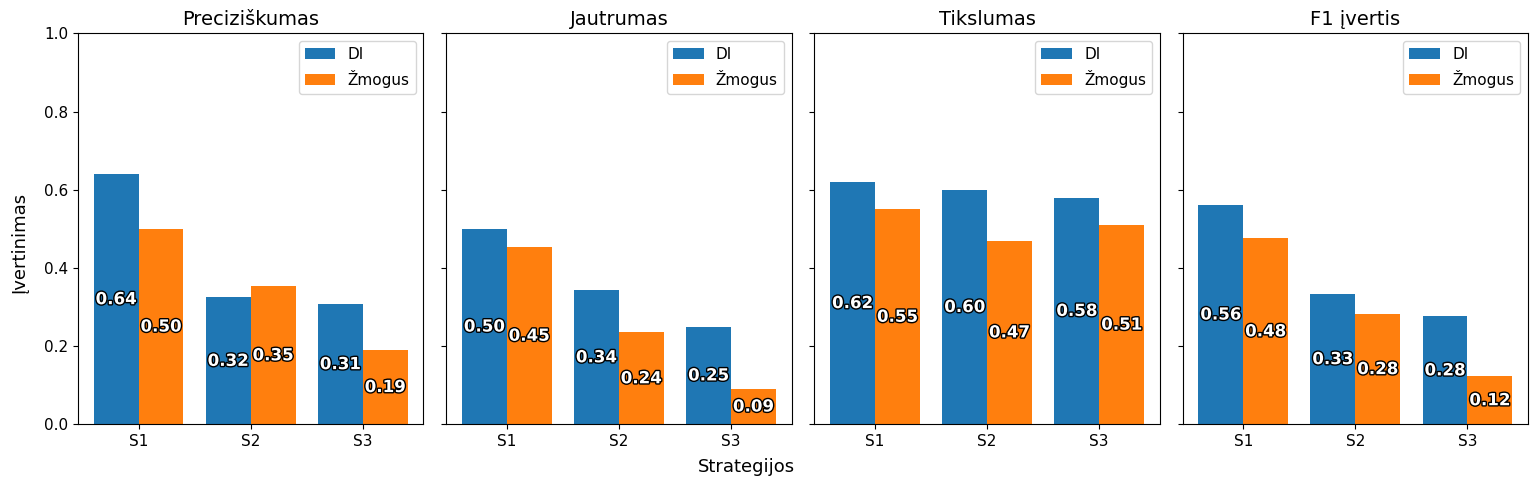

In [ ]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects

final_judged_file = "test_judged_final.jsonl"  # after human evaluation


plt.rcParams.update({
    'font.size':        12,
    'axes.titlesize':   14,
    'axes.labelsize':   13,
    'xtick.labelsize':  11,
    'ytick.labelsize':  11,
    'legend.fontsize':  11,
})


with open(final_judged_file, 'r', encoding='utf-8') as f:
    records = [json.loads(line) for line in f if line.strip()]


group_names = ['S1', 'S2', 'S3']
metrics     = ['Preciziškumas', 'Jautrumas', 'Tikslumas', 'F1 įvertis']
results     = {m: {'DI': [], 'Žmogus': []} for m in metrics}

def compute_confusion(vals):
    tn = vals.count(0)
    fp = vals.count(1)
    tp = vals.count(2)
    fn = vals.count(3)
    return tn, fp, fn, tp

def precision(tp, fp):         return tp/(tp+fp) if tp+fp>0 else 0.0
def recall(tp, fn):            return tp/(tp+fn) if tp+fn>0 else 0.0
def accuracy(tp, tn, fp, fn):  return (tp+tn)/(tp+tn+fp+fn) if tp+tn+fp+fn>0 else 0.0
def f1(p, r):                  return 2*p*r/(p+r) if (p+r)>0 else 0.0

for n in (1, 2, 3):
    ai_key    = f"aiS{n}Verdict"
    human_key = f"humanS{n}Verdict"
    subset    = [rec for rec in records if human_key in rec]

    ai_vals = [int(rec[ai_key]) for rec in subset]
    hu_vals = [int(rec[human_key]) for rec in subset]

    tn_ai, fp_ai, fn_ai, tp_ai = compute_confusion(ai_vals)
    tn_hu, fp_hu, fn_hu, tp_hu = compute_confusion(hu_vals)

    p_ai, r_ai = precision(tp_ai, fp_ai), recall(tp_ai, fn_ai)
    a_ai, f1_ai = accuracy(tp_ai, tn_ai, fp_ai, fn_ai), f1(p_ai, r_ai)

    p_hu, r_hu = precision(tp_hu, fp_hu), recall(tp_hu, fn_hu)
    a_hu, f1_hu = accuracy(tp_hu, tn_hu, fp_hu, fn_hu), f1(p_hu, r_hu)

    results['Preciziškumas']['DI'].append(p_ai)
    results['Preciziškumas']['Žmogus'].append(p_hu)
    results['Jautrumas']['DI'].append(r_ai)
    results['Jautrumas']['Žmogus'].append(r_hu)
    results['Tikslumas']['DI'].append(a_ai)
    results['Tikslumas']['Žmogus'].append(a_hu)
    results['F1 įvertis']['DI'].append(f1_ai)
    results['F1 įvertis']['Žmogus'].append(f1_hu)

x     = np.arange(len(group_names))
width = 0.4

fig, axes = plt.subplots(1, len(metrics), figsize=(16, 5), sharey=True)
for ax, metric in zip(axes, metrics):
    ai_scores = results[metric]['DI']
    hu_scores = results[metric]['Žmogus']

    bars_ai = ax.bar(x - width/2, ai_scores, width, label='DI')
    bars_hu = ax.bar(x + width/2, hu_scores, width, label='Žmogus')

    for bar in (*bars_ai, *bars_hu):
        h = bar.get_height()
        txt = ax.text(
            bar.get_x() + bar.get_width()/2,
            h/2,
            f"{h:.2f}",
            ha='center', va='center',
            color='white', weight='bold'
        )
        txt.set_path_effects([
            path_effects.Stroke(linewidth=2, foreground='black'),
            path_effects.Normal()
        ])

    ax.set_title(metric)
    ax.set_xticks(x)
    ax.set_xticklabels(group_names)
    ax.set_ylim(0, 1)
    ax.legend()

fig.text(0.5, 0.04, 'Strategijos', ha='center', fontsize=13)
fig.text(0.04, 0.5, 'Įvertinimas', va='center', rotation='vertical', fontsize=13)

plt.tight_layout(rect=[0.05, 0.05, 1, 1])
plt.show()


Cohan kappa calculation

In [ ]:
import os
import json
from sklearn.metrics import cohen_kappa_score, accuracy_score


final_judged_file = "test_judged_final.jsonl"  # final file after human evaluation

if not os.path.exists(final_judged_file):
    print(f"Error: Judged file '{final_judged_file}' not found.")
else:

    records = []
    with open(final_judged_file, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if line:
                records.append(json.loads(line))

    for n in (1, 2, 3):
        ai_key = f"aiS{n}Verdict"
        human_key = f"humanS{n}Verdict"
        subset = [rec for rec in records if ai_key in rec and human_key in rec]
        ai_vals = [int(rec[ai_key]) for rec in subset]
        human_vals = [int(rec[human_key]) for rec in subset]
        if ai_vals and human_vals:
            kappa = cohen_kappa_score(human_vals, ai_vals)
            acc = accuracy_score(human_vals, ai_vals)
            print(f"Strategy S{n}: Cohen's kappa = {kappa:.3f}")
        else:
            print(f"Strategy S{n}: No overlapping records to compute kappa.")


Strategy S1: Cohen's kappa = 0.691
Strategy S2: Cohen's kappa = 0.749
Strategy S3: Cohen's kappa = 0.732
